# Algorithmic Fairness, Accountability, and Ethics, Spring 2026
# Exercise 3

## Task 0 (Setup)

We use the same dataset as in week 2. If you missed to install the module, please carry out the installation tasks at <https://github.com/zykls/folktables#basic-installation-instructions>.

After successful installation, you should be able to run the following code to generate a prediction task.
To make your life easier, we made the `BasicProblem`-magic from the `folktables` package (see exercises of week 2) explicit in this task.
This way, you can get access to different encodings of the data. 

**Note**: Some Windows users could not run the line `acs_data = data_source.get_data(states=["CA"], download=True)`. The dataset is available as a zip file on learnIT under week 2. Unzip it in the notebook's location, and set `download` to `False` in the code below.

A description of the fields in this dataset is available [here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2014-2018.pdf).

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [ ]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 25000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

pd.get_dummies() creates our one-hot encoding, but why do we drop first??

In [3]:
data_original.ENG.unique() #ENG has 5 possible values

array([ 1., nan,  3.,  2.,  4.])

In [4]:
# One-hot encoded columns
data[[x for x in data.columns if 'ENG' in x]].columns

#We only create 4 one-hot encoded columns for ENG, because we dropped the first one

Index(['ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan'], dtype='object')

We do this to avoid multi-collinarity, which can be a problem for linear models such as logistic regression.

Often we choose to drop the most common, or most 'baseline' variable - in this case we have just dropped the first though...

In [5]:
#Run this cell to use categorical features instead
catagorical=False
if catagorical:
    data, data_original, target, group = data_processing(acs_data, feature_names, target_name)
    data_original = data_original.dropna(axis=1)
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_original[['AGEP', 'CIT', 'COW', 'SCHL', 'MAR', 'HINS1', 'HINS2', 'HINS4', 'RAC1P',
        'SEX']], target, group, test_size=0.2, random_state=0)

# Task 1 (Logistic regression)

1) Train a logistic regression classifier on the training dataset. In our setup, the following parameters worked out well: `LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")`. Which scaling considerations do you think are necessary?
2) Report on the accuracy of the model. (If you are interested: How is the classification accuracy on the original dataset with categorial input?)
3) Report on the model weights (sort them by weight). Which weights are most important? Explain the influence of the most important weights. (For example, "being female instead of male increases/decreases the odds for ... by ...".)
4) Find a negative or a positive instance, and discuss how you can use the weights discussion to create a counterfactual. (E.g., "By increasing/decreasing feature ... to ..., the person is classified as ...").

In [6]:
clf = LogisticRegression(max_iter=5000, penalty='l2', C=0.98497534359086438, tol=1e-4, solver='saga', random_state=42)
# C is the inverse of regularization strength, smaller values specify stronger regularization

#We have quite a few features, so this cells takes around 2-3 mins to run on my laptop
clf.fit(X_train, y_train)

LogisticRegression(C=0.9849753435908644, max_iter=5000, random_state=42,
                   solver='saga')

In [7]:
clf.score(X_test, y_test) ## categorical features ~0.75, one-hot ~0.77

0.7696062147037027

In [8]:
weights = {}
for i in range(len(clf.coef_[0])):
    weights[clf.feature_names_in_[i]] = [float(clf.coef_[0][i])]

for k,v in weights.items():
    weights[k].append(float(np.exp(v[0]))) # odds ratios

sorted(weights.items(), key=lambda x: x[1], reverse=True)
#list of features, with both weights and odds ratios

[('SCHL_24.0', [2.448933784691078, 11.575997631109544]),
 ('SCHL_23.0', [2.4205847753376863, 11.252437539264513]),
 ('SCHL_22.0', [2.232536332035017, 9.323483565975234]),
 ('SCHL_21.0', [1.7323790091566094, 5.654089050552248]),
 ('SCHL_20.0', [0.9844230367738743, 2.6762673310553495]),
 ('HINS4_2', [0.8350845733925355, 2.3050089824732463]),
 ('SCHL_19.0', [0.6980746655375485, 2.0098792899925426]),
 ('SCHL_18.0', [0.6500486268918877, 1.9156339780754512]),
 ('COW_5.0', [0.6084457228396124, 1.8375730801783339]),
 ('SCHL_17.0', [0.6080772897424007, 1.8368961821405283]),
 ('SCHL_3.0', [0.45515448996518093, 1.5764169048154066]),
 ('SCHL_16.0', [0.4357817057028019, 1.5461712375436638]),
 ('SCHL_2.0', [0.3629574810088465, 1.4375747337143356]),
 ('COW_7.0', [0.26744528445213545, 1.3066221353341887]),
 ('SCHL_12.0', [0.23823210450767643, 1.2690037001244097]),
 ('SCHL_15.0', [0.2008666938874943, 1.2224617993307982]),
 ('SCHL_10.0', [0.16903182506417233, 1.1841578242230437]),
 ('SCHL_13.0', [0.1155

### Why odds ratios?

Log-odds are not particularly intuitive to interpret, so instead we can consider **odds ratios** instead: $e^{\beta_i}$

- If $e^{\beta_i} = 2$, then a **1-unit increase in $x_i$ doubles the odds**.
- If $e^{\beta_i} = 0.5$, then a **1-unit increase in $x_i$ halves the odds**.
- If $e^{\beta_i} = 1$, then a **1-unit increase in $x_i$ doesn't change the odds**.


In [9]:
# In our dataset, we can see:

weights['SEX_2'][1] #odds ratio is 0.44, so being female instead of male decreases odds by 66%  #one-hot encoded features

# weights['SEX'][1] #odds ration 0.46 so similar #catagorical features

# This indicates that there is some bias, as in an ideal world, someone's gender should not affect their income.

0.4408383253560944

We would expect that some things, such as education level (SCHL), to be important in predicting income. However, we would hope that other things, such as gender, race etc, were not. Some things such as age could be bias as real world knowledge tells us ageism is a thing, but could also reasonably be expected to be important, for example, few 18yos will have the experience to be in a position of senority.

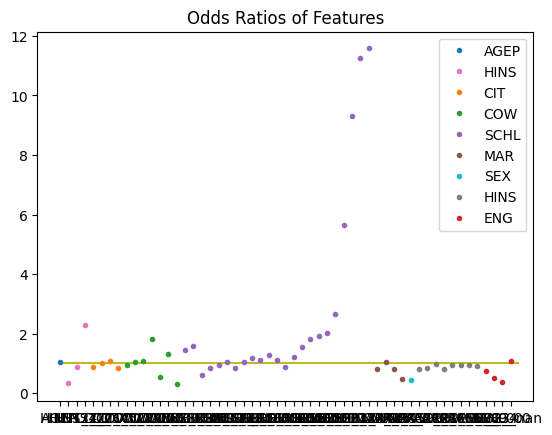

In [10]:
plt.hlines(xmin=0, xmax=55, y=1, color = 'tab:olive'); # log-odds of 1 represents odds of 1:1

for k,v in weights.items():
    c = 'blue'
    if 'AGEP' in k:
        c = 'tab:blue'
    if 'CIT' in k:
        c='tab:orange'
    if 'COW' in k:
        c = 'tab:green'
    if 'ENG' in k:
        c = 'tab:red'
    if 'SCHL' in k:
        c = 'tab:purple'
    if 'MAR' in k:
        c = 'tab:brown'
    if 'HINS' in k:
        c = 'tab:pink'
    if 'RAC' in k:
        c = 'tab:gray'
    if 'SEX' in k:
        c = 'tab:cyan'
    

    plt.plot(k, v[1], '.', color = c)

patches = [Line2D([0], [0], marker='o', color='white', label='AGEP', markerfacecolor='tab:blue', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='HINS', markerfacecolor='tab:pink', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='CIT', markerfacecolor='tab:orange', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='COW', markerfacecolor='tab:green', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='SCHL', markerfacecolor='tab:purple', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='MAR', markerfacecolor='tab:brown', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='SEX', markerfacecolor='tab:cyan', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='HINS', markerfacecolor='tab:gray', markersize=5),
           Line2D([0], [0], marker='o', color='white', label='ENG', markerfacecolor='tab:red', markersize=5),
           ]

plt.title("Odds Ratios of Features")
plt.legend(handles=patches);

Some features have a much greater affect than others, as we (probably) expected, and we can see SEX is below the line, indicating a negative effect.

Lets search for a result close to the boundary, and see if changing gender will flip the result.

In [ ]:
y_pred_prob = clf.predict_proba(X_test)[:,0] #get the probabilities for the predictions for class 0

cf = X_test.iloc[[np.argmin(abs(y_pred_prob - 0.5))]].copy() #this is the person who is closest to the threshold of the two classes, so likely a good target for a counterfactual

truth = y_test[[np.argmin(abs(y_pred_prob - 0.5))]] #get the actual value for this person. It doesn't actually matter, we are interested in whether changing from female to male will change the prediction

orig_pred = clf.predict(cf)[0]

print(f'Original prediction: earns over 25000? {orig_pred}\n') # Initially predicted False,

print('Changing SEX from True to False\n')
cf2 = cf.copy()
cf2['SEX_2'] = False #Switch sex from True (female) to False (male)

new_pred = clf.predict(cf2)[0]
print(f'New prediction: earns over 25000? {new_pred}\n')

print(f'Counterfactual example {"not " if new_pred == orig_pred else ""}found\n')

print(f'Actual label: {truth[0]}') #So in this instance, the model incorrectly classified the person as earning less 25000, when they actually earn more than 25000, because they are female.

Original prediction: earns over 25000? False

Changing SEX from True to False

New prediction: earns over 25000? True

Counterfactual example found

Actual label: True


# Task 2 (Decision tree)

1. Train a decision tree classifier on the training dataset. (You can work on the original dataset or on the one-hot encoded one.) The following parameter choices worked well in our setup: `(DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_features="auto", max_depth = 15, criterion = "gini", random_state = 0))` Report on its accuracy. Visualize the tree using `plot_tree` from `sklearn`. Which parameters can you change the adapt the size of the tree? Try to find parameters that make the tree easier to understand.
2. For two training examples, explain their classification given the decision tree.
3. Compute feature importance as shown in the lecture. Which features are most important?
4. Provide a counterfactual, as in Task 2.


In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Accuracy: 76.04%


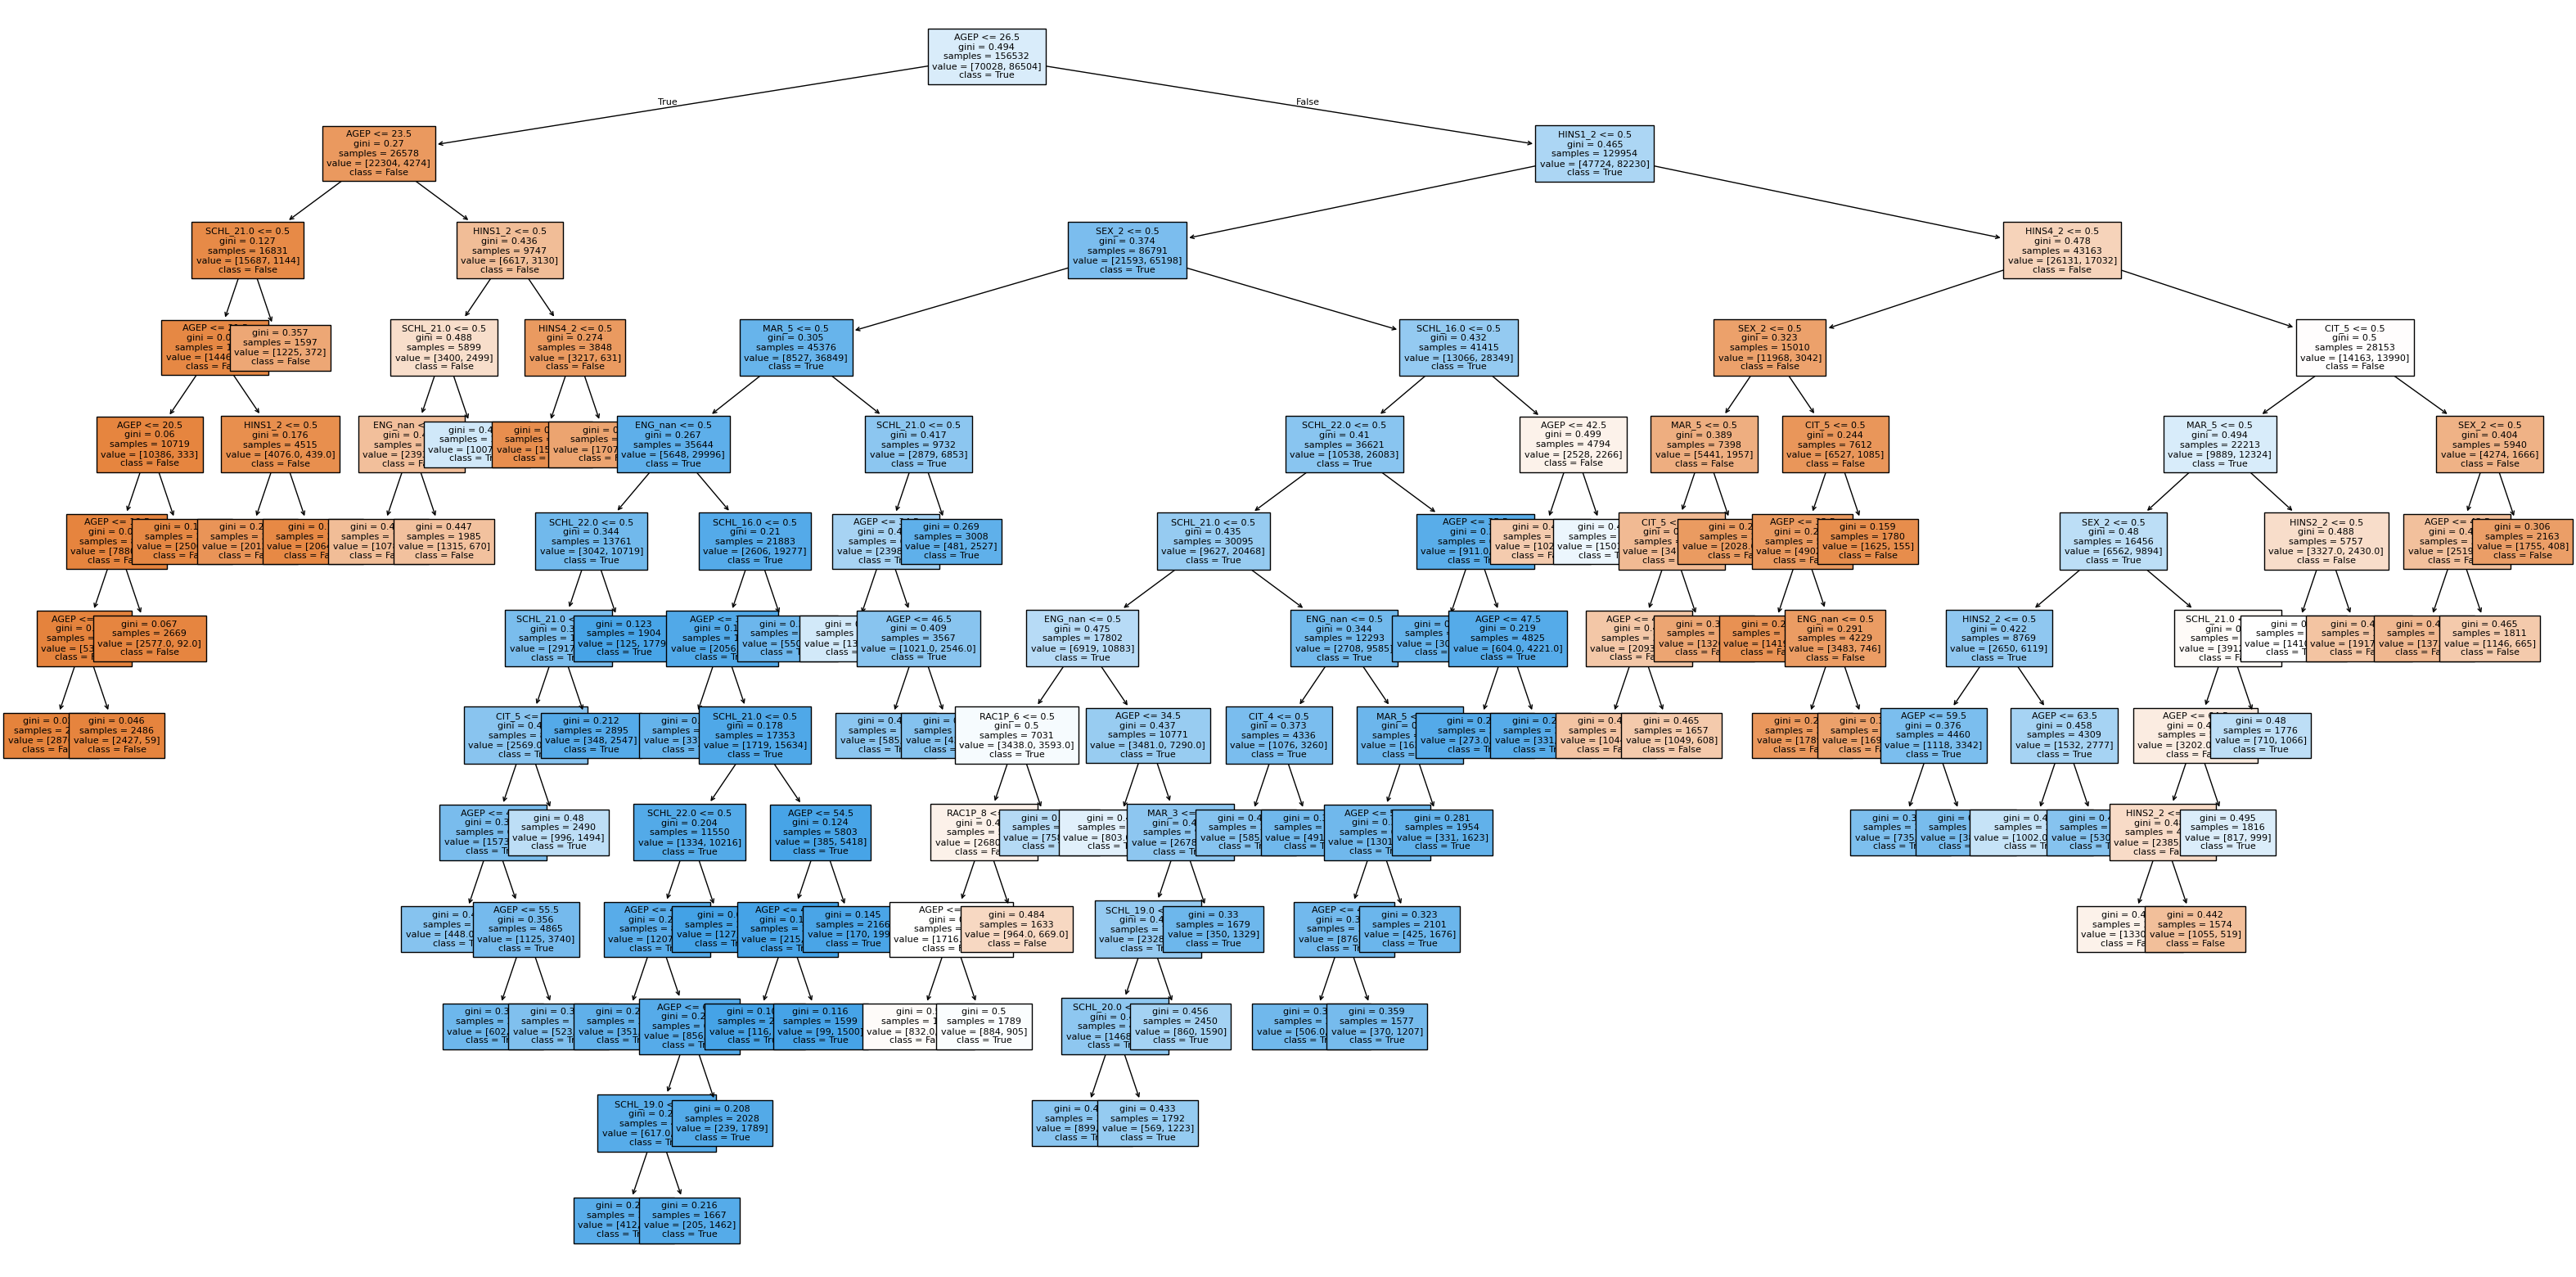

In [13]:
dt_clf = DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_depth = 15, criterion = "gini", random_state = 0)

dt_clf.fit(X_train, y_train)

print(f'Accuracy: {dt_clf.score(X_test, y_test):.2%}')

_, ax = plt.subplots(figsize=(40, 20))

plot_tree(dt_clf, filled=True, feature_names = X_train.columns, class_names = ['False', 'True'], ax=ax, fontsize=8);

This is pretty hard to read.

Accuracy: 75.29%


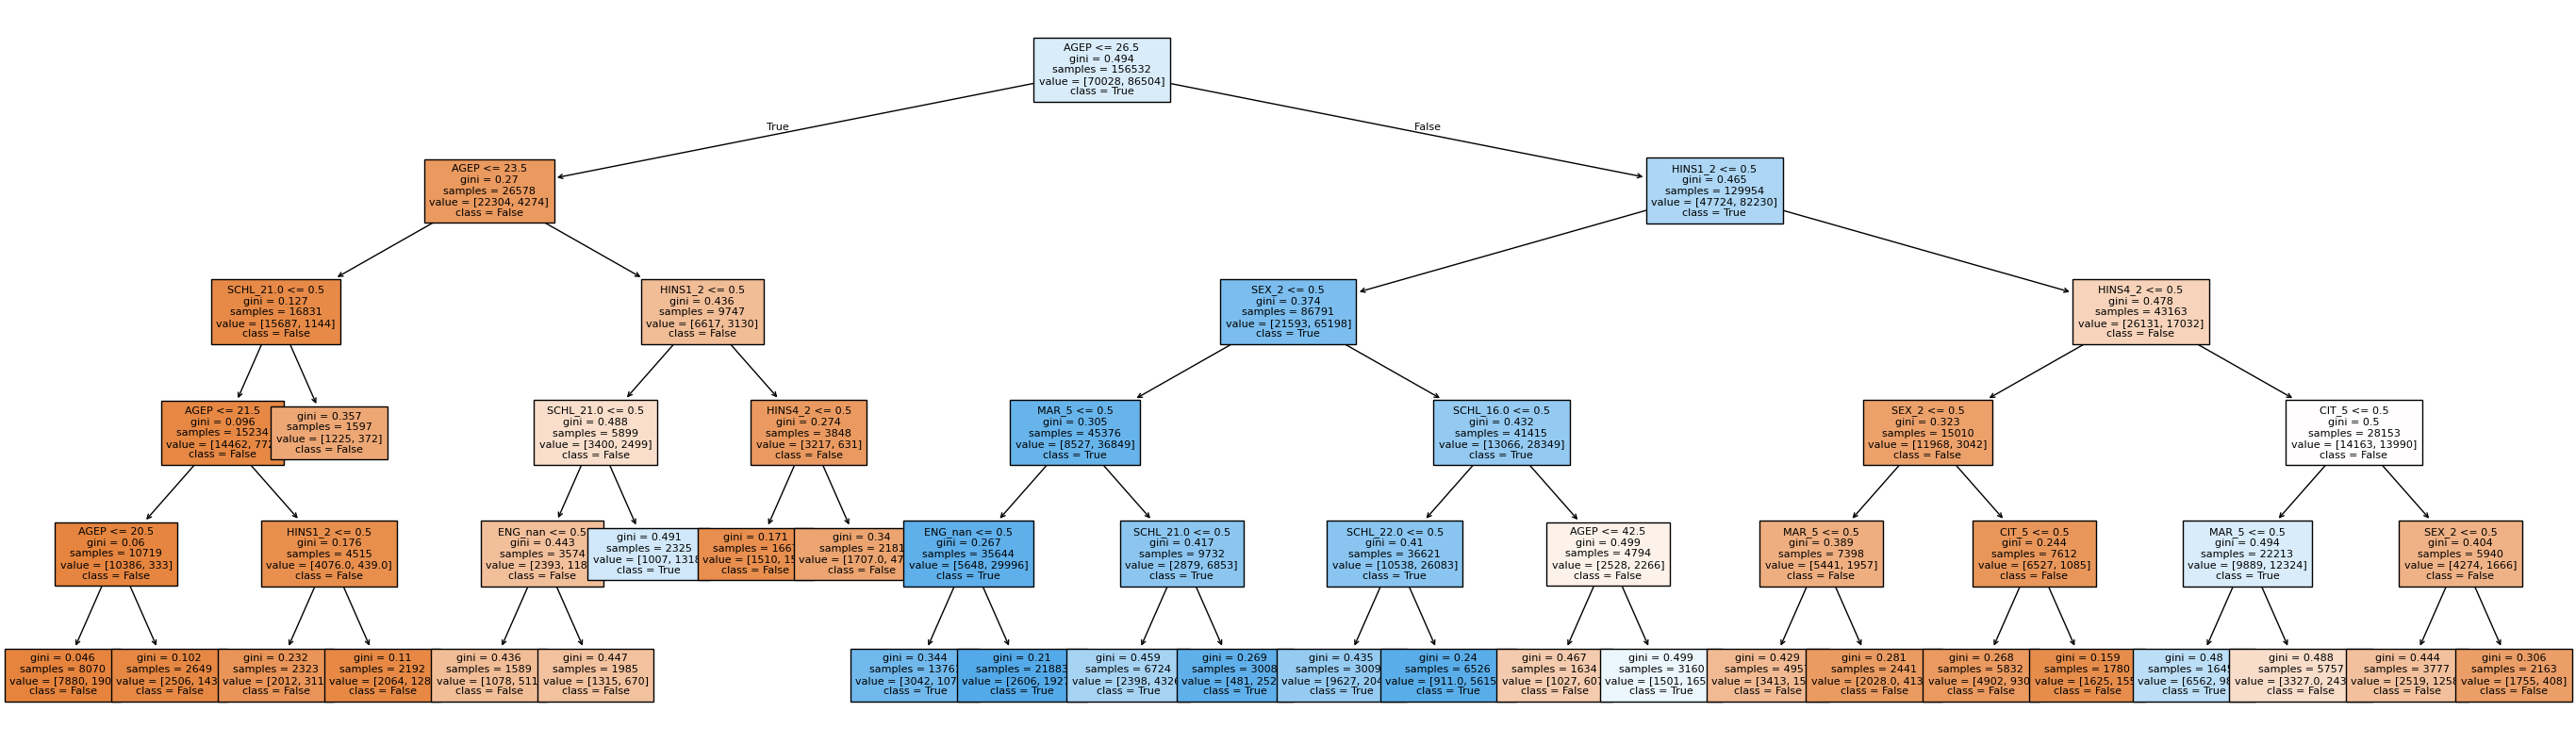

In [14]:
# Making the tree much shorter, only reduces accuracy by 0.75%
dt_clf_short = DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_depth = 5, criterion = "gini", random_state = 0)

dt_clf_short.fit(X_train, y_train)

print(f'Accuracy: {dt_clf_short.score(X_test, y_test):.2%}')

_, ax = plt.subplots(figsize=(35, 10))

plot_tree(dt_clf_short, filled=True, feature_names = X_train.columns, class_names = ['False', 'True'], ax=ax, fontsize=8);

We can view the feature importance using tree.feature_importances_

In [15]:
sorted([x for x in zip(dt_clf.feature_names_in_, dt_clf.feature_importances_)], key=lambda x: x[1], reverse=True) #Many are 0, so the model is not using them in its decision making - a deeper tree might

[('AGEP', np.float64(0.42588905917519326)),
 ('HINS1_2', np.float64(0.2962316157088458)),
 ('HINS4_2', np.float64(0.06668827447735469)),
 ('SEX_2', np.float64(0.047338326923551506)),
 ('SCHL_21.0', np.float64(0.03951569332145592)),
 ('CIT_5', np.float64(0.03285871883453128)),
 ('MAR_5', np.float64(0.02456540150091736)),
 ('SCHL_16.0', np.float64(0.02056866908099799)),
 ('SCHL_22.0', np.float64(0.01887521915729721)),
 ('ENG_nan', np.float64(0.016485362646125087)),
 ('HINS2_2', np.float64(0.005999545307605934)),
 ('RAC1P_6', np.float64(0.0023195081624971534)),
 ('MAR_3', np.float64(0.0012453357465831393)),
 ('RAC1P_8', np.float64(0.0006844865162970982)),
 ('SCHL_19.0', np.float64(0.0003431611035141809)),
 ('CIT_4', np.float64(0.0003241582111495508)),
 ('SCHL_20.0', np.float64(6.74641260828351e-05)),
 ('CIT_2', np.float64(0.0)),
 ('CIT_3', np.float64(0.0)),
 ('COW_2.0', np.float64(0.0)),
 ('COW_3.0', np.float64(0.0)),
 ('COW_4.0', np.float64(0.0)),
 ('COW_5.0', np.float64(0.0)),
 ('COW_6.

In [16]:
y_pred_prob = dt_clf.predict_proba(X_test)[:,0] #get the probabilities for the predictions for class 0

cands = X_test[abs(y_pred_prob - 0.5) < 0.0002].copy() #get the people who are closest to the threshold of the two classes, there are ~700 with an equally close probability because of the nature of the model
truths = y_test[abs(y_pred_prob - 0.5) < 0.0002] #get the truths too
y_pred = dt_clf.predict(cands) #get the predictions for these people
cols = cands.columns

cands['truth'] = truths
cands['pred'] = y_pred

cands

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan,truth,pred
300454,37,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
201243,36,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,True
264074,49,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
90165,27,True,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,True
153791,42,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358608,37,True,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,True
135709,42,True,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
272562,32,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
194529,83,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,True


In [17]:
cands = cands[cands.truth != cands.pred] # Lets try to flip someone misclassified again

cands = cands[cands.SEX_2 == False] # all the misclassified people should be false but were misclassified to True

In [ ]:
cf_dt = cands.sample(1).copy() #pick a random person from the candidates

orig_pred = dt_clf.predict(cf_dt[cols])[0]

print(f'Original prediction: earns over 25000? {orig_pred}\n') # Initially predicted False,

print('Changing SEX from True to False\n')
cf_dt2 = cf_dt.copy()
cf_dt2['SEX_2'] = True #Switch sex from False (male) to True (female)

new_pred = clf.predict(cf_dt2[cols])[0]
print(f'New prediction: earns over 25000? {new_pred}\n')

print(f'Counterfactual example {"not " if new_pred == orig_pred else ""}found\n')

print(f'Actual label: {truth[0]}') #If this person had been female, and everything else the same, they would have been misclassified,

Original prediction: earns over 25000? True

Changing SEX from True to False

New prediction: earns over 25000? False

Counterfactual example found

Actual label: True


In [19]:
#Looking at permutation importance

from sklearn.inspection import permutation_importance

perm_importances = permutation_importance(dt_clf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)


In [20]:
sorted([x for x in zip(dt_clf.feature_names_in_, perm_importances.importances_mean)], key=lambda x: x[1], reverse=True)

[('AGEP', np.float64(0.1018398793856847)),
 ('HINS1_2', np.float64(0.08075281731530932)),
 ('SEX_2', np.float64(0.013653438274602003)),
 ('HINS4_2', np.float64(0.011205376536427059)),
 ('CIT_5', np.float64(0.008925970408606553)),
 ('SCHL_21.0', np.float64(0.008925970408606553)),
 ('SCHL_16.0', np.float64(0.006856106099711235)),
 ('MAR_5', np.float64(0.005634630618659442)),
 ('ENG_nan', np.float64(0.004321161168323417)),
 ('SCHL_22.0', np.float64(0.0024991694988883983)),
 ('RAC1P_6', np.float64(0.0016916668796156497)),
 ('HINS2_2', np.float64(0.0012291416451588265)),
 ('RAC1P_8', np.float64(0.0009148289167710044)),
 ('CIT_2', np.float64(0.0)),
 ('CIT_3', np.float64(0.0)),
 ('CIT_4', np.float64(0.0)),
 ('COW_2.0', np.float64(0.0)),
 ('COW_3.0', np.float64(0.0)),
 ('COW_4.0', np.float64(0.0)),
 ('COW_5.0', np.float64(0.0)),
 ('COW_6.0', np.float64(0.0)),
 ('COW_7.0', np.float64(0.0)),
 ('COW_8.0', np.float64(0.0)),
 ('SCHL_2.0', np.float64(0.0)),
 ('SCHL_3.0', np.float64(0.0)),
 ('SCHL_4.

# Task 3 (Comparison)

Now you have both an interpretable logistic regression model and an interpretable decision tree model. Reflect on the explanations you can obtain from these two models: Do explanations from one model translate to the other? Do the counterfactuals from one work in the other model?  

In [ ]:
#Here I consider the person who was close to the boundary for the LG model.

print(f'LG prob class 0: {clf.predict_proba(cf)[0][0]:.3f}\nDT prob class 0: {dt_clf.predict_proba(cf)[0][0]:.3f}') # We can see they are still close to the decision boundary, but not as close as with the logistic regression model

LG prob class 0: 0.500
DT prob class 0: 0.433


In [ ]:
#And the person found for the DT model

print(f'LG prob class 0: {clf.predict_proba(cf_dt[cols])[0][0]:.3f}\nDT prob class 0: {dt_clf.predict_proba(cf_dt[cols])[0][0]:.3f}')  # This person is not particularly close to the decision boundary for the logistic regression model

LG prob class 0: 0.369
DT prob class 0: 0.500


The probabilities assigned by each of the models for the two individuals are quite different, as they are relying on different features for their decisions. This means explanations cannot easily be transfered from one model to the other.

The most important features: 

DT: 'AGEP', 'HINS1_2', 'HINS4_2', 'SEX_2', 'SCHL_21.0', 

LG:'SCHL_24.0','SCHL_23.0','SCHL_22.0','SCHL_21.0','SCHL_20.0',

As the LG is mostly relying on features relating to education level, this may imply it is 'fairer' than the DT which places high importance on age and sex. We could use one of the metrics from last week to look more into this, and put number on how fair the models actually are.